In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
from dev import load_network_names

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
with open("/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/aim2_prefixes.txt") as f:
    prefixes = f.read().splitlines()

In [5]:
prefixes = [prefixes[i] for i in range(len(prefixes)) if i+1 not in [7]]

In [6]:
names = load_network_names("/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/network_names.txt")

## LOAD RESULTS

In [7]:
cv_results = []
corum_results = []
kegg_results = []
panther_results = []
for prefix in prefixes:
    try:
        cv_results.append(pd.read_csv("/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/"+prefix+"_L3_results.tsv", sep="\t"))
        if "network" not in cv_results[-1].columns:
            print("CV network missing:", prefix)
            
    except FileNotFoundError:
        print("CV missing:", prefix)
    try:
        corum_results.append(pd.read_csv("/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/"+prefix+"_L3_corum_results.tsv", sep="\t"))
    except FileNotFoundError:
        print("Corum missing:", prefix)
        
    try:
        kegg_results.append(pd.read_csv("/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/"+prefix+"_L3_kegg_results.tsv", sep="\t"))
    except FileNotFoundError:
        print("KEGG missing:", prefix)
    try:
        panther_results.append(pd.read_csv("/cellar/users/snwright/Data/Network_Analysis/Edge_Prediction/"+prefix+"_L3_panther_results.tsv", sep="\t"))
    except FileNotFoundError:
        print("Panther missing:", prefix)

In [8]:
cv_df = pd.concat(cv_results)
cv_df['network'] = cv_df.network.map(names)
corum_df = pd.concat(corum_results)
corum_df['network'] = corum_df.network.map(names)

In [10]:
kegg_df = pd.concat(kegg_results)
kegg_df['network'] = kegg_df.network.map(names)
panther_df = pd.concat(panther_results)
panther_df['network'] = panther_df.network.map(names)

## Get network stats

In [11]:
from dev import NetworkStats

stats_df = NetworkStats("/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/aim2_prefixes.txt", 
                        '/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/')
sizes_df = pd.DataFrame({"Nodes": stats_df.network_node_counts, "Edges": stats_df.network_edge_counts})
sizes_df['Density'] = sizes_df['Edges'] / (sizes_df['Nodes'] * (sizes_df['Nodes'] - 1))
sizes_df.index = sizes_df.index.map(names)

In [12]:
sizes_df['network'] = sizes_df.index

## Visualize VC results

In [13]:
cv_df = corum_df.sort_values(by="network")


In [72]:
def plot_all_metrics(plot_df, net_order=None, metrics=['AUROC', 'AUPRC', 'P@500', 'NDCG']):
    if net_order is None:
        net_order = plot_df.network.unique()[::-1]
    if net_order in ['AUPRC', 'AUROC', 'P@500', 'NDCG']:
        net_order = plot_df.groupby('network')[net_order].mean().sort_values(ascending=False).index
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15,6))
    sns.stripplot(data = plot_df, x='network', y='AUROC', ax=ax1, order=net_order)
    sns.stripplot(data = plot_df, x='network', y='AUPRC', ax=ax2, order=net_order)
    plot_baseline_bars(plot_df, 'AUPRC', 'baselineAUPRC', ax2, order=net_order)
    #sns.stripplot(data=corum_df, x='network', y='baselineAUPRC', ax=ax2, color="black")
    sns.stripplot(data = plot_df, x='network', y='P@500', ax=ax3, order=net_order)
    sns.stripplot(data = plot_df, x='network', y='NDCG', ax=ax4, order=net_order)
    ax3.tick_params(axis='x', rotation=90)
    ax4.tick_params(axis='x', rotation=90)
#ax2.set_yscale("log")

def plot_metric(plot_df, net_order=None, metric="AUPRC", figsize=(8, 5), ax=None, kind='strip', **kwargs):
    if net_order is None:
        net_order = plot_df.network.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('network')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    if kind == 'strip':
        sns.stripplot(data = plot_df, x='network', y=metric, ax=ax, order=net_order, **kwargs)
        if metric == "AUPRC":
            plot_baseline_bars(plot_df, 'AUPRC', 'baselineAUPRC', ax, order=net_order)
    if kind == 'bar':
        sns.barplot(data = plot_df, x='network', y=metric, ax=ax, order=net_order, **kwargs)
    ax.tick_params(axis='x', rotation=90)

def plot_baseline_bars(data, metric, base, ax, order):
    #net_order = [x.get_text() for x in ax.get_xticklabels()]
    metric = "AUPRC"
    base = 'baselineAUPRC'
    means = data.groupby('network')[metric].mean()
    bases = data.groupby('network')[base].mean()
    for i, network in enumerate(order):
        ax.vlines(network, means[network], bases[network], color="grey", linewidth=0.5, linestyles='-')
        ax.hlines(bases[network], i-.4, i+.4, color="grey", linewidth=0.5)

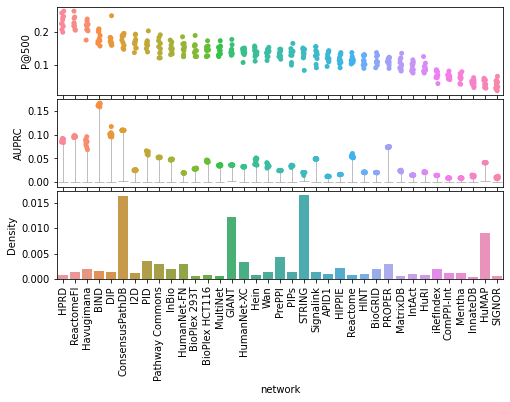

In [67]:
_, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace':0.05})
plot_metric(corum_df, net_order="P@500", metric="P@500", figsize=(8, 2), ax=axs[0])
axs[0].set_xlabel('')

plot_metric(corum_df, net_order="P@500", metric="AUPRC", figsize=(8, 2), ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylim((-0.01, 0.175))
plot_metric(sizes_df, kind='bar',net_order=cv_df.groupby('network')['P@500'].mean().sort_values(ascending=False).index, metric='Density', figsize=(8,2), ax=axs[2])
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/edge_predictions_cv_precision.svg', bbox_inches='tight', transparent=True, dpi=500)

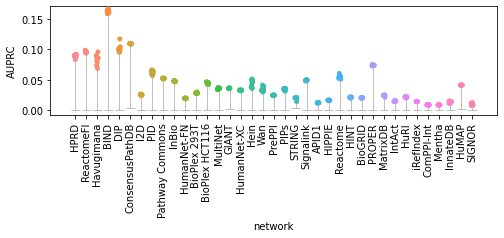

In [26]:
plot_metric(cv_df, net_order="P@500", metric="AUPRC", figsize=(8, 2))

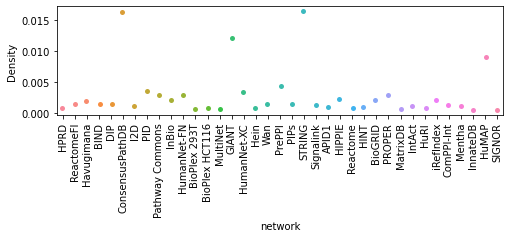

In [33]:
plot_metric(sizes_df, net_order=cv_df.groupby('network')['P@500'].mean().sort_values(ascending=False).index, metric='Density', figsize=(8,2))

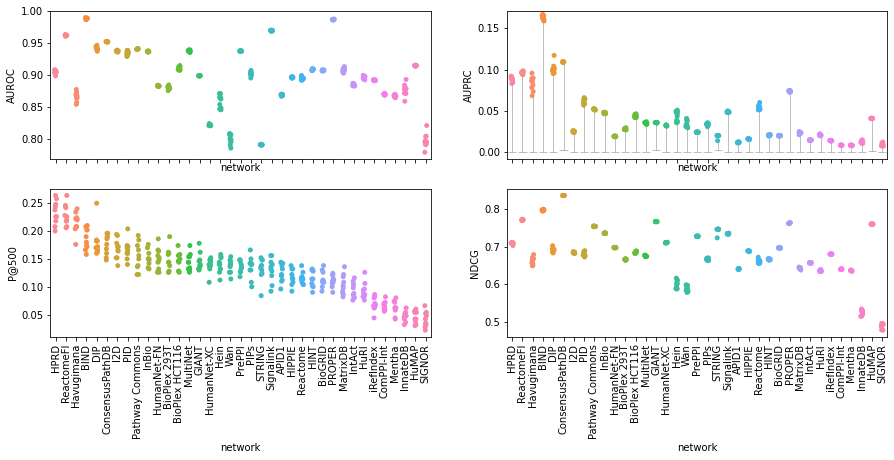

In [18]:

plot_all_metrics(cv_df, net_order="P@500")

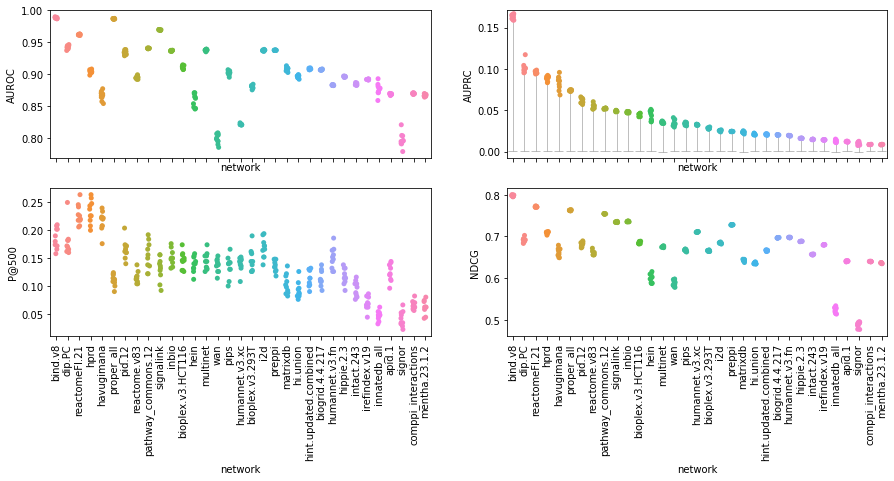

In [14]:
plot_all_metrics(cv_df, net_order="AUPRC")

## CORUM RESULTS

In [99]:
names.values()

dict_values(['BIND', 'BioGRID', 'BioPlex 293T', 'BioPlex HCT116', 'ConsensusPathDB', 'DIP', 'GeneMANIA', 'GIANT', 'HuRI', 'HINT', 'HPRD', 'HumanNet-FN', 'HumanNet-XC', 'InBio', 'IntAct', 'iRefIndex', 'Mentha', 'MultiNet', 'Pathway Commons', 'PID', 'PROPER_Consensus', 'PROPER', 'Reactome', 'ReactomeFI', 'STRING', 'HIPPIE', 'Wan', 'Havugimana', 'ComPPI', 'ComPPI-Int', 'Signalink', 'SIGNOR', 'APID', 'APID1', 'APID2', 'MatrixDB', 'I2D', 'Hein', 'InnateDB', 'PrePPI', 'HuMAP', 'PIPs', 'Colocal.', 'Coexp. 97', 'Coexp. 90', 'Genetic', 'Domain', 'Pathway', 'Physical', 'Predicted', 'Genetic 90'])

In [ ]:
ppi_classification = {
    'PPI_only': ['BioPlex 293T', 'BioPlex HCT116', 'DI
                 P', 'HPRD', 'HuRI', 'Havugimana', 'Wan', 'Hein'],
}
signalling_classification = {
    'Signalling_only'  : ['PID', 'Signalink', 'SIGNOR'],
    'Signalling_only': ['ConsensusPathDB', 'MultiNet', 'PathwayCommons']
}

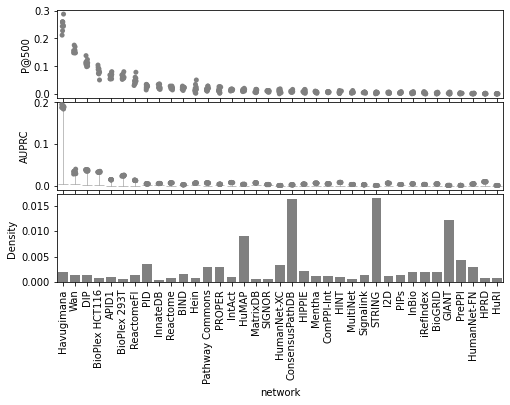

In [79]:
_, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace':0.05})
plot_metric(corum_df, net_order="P@500", metric="P@500", figsize=(8, 2), ax=axs[0], color='grey')
axs[0].set_xlabel('')

plot_metric(corum_df, net_order="P@500", metric="AUPRC", figsize=(8, 2), ax=axs[1], color='grey')
axs[1].set_xlabel('')
axs[1].set_ylim((-0.01, 0.2))
plot_metric(sizes_df, kind='bar',net_order=corum_df.groupby('network')['P@500'].mean().sort_values(ascending=False).index, metric='Density', figsize=(8,2), ax=axs[2], color='grey')
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/edge_predictions_corum_precision.svg', bbox_inches='tight', transparent=True, dpi=500)

In [15]:
corum_order = corum_df.groupby('network')['AUPRC'].mean().sort_values(ascending=False).index

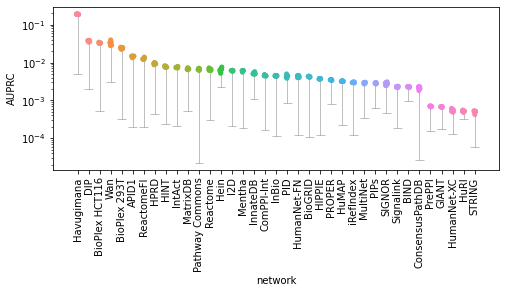

In [17]:
plot_metric(corum_df, corum_order, metric="AUPRC", figsize=(8, 3))
plt.yscale("log")

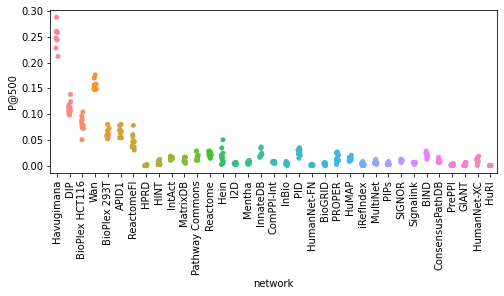

In [97]:
plot_metric(corum_df, corum_order, metric="P@500", figsize=(8,3))

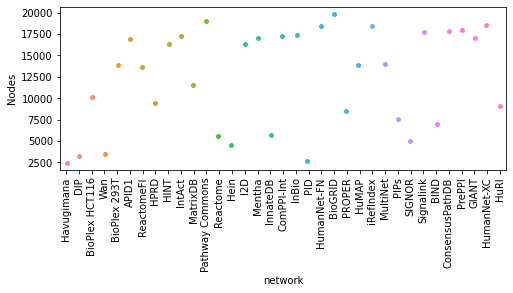

In [93]:
plot_metric(sizes_df, corum_order, metric="Nodes", figsize=(8,3))

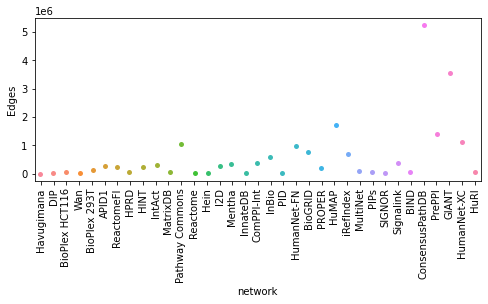

In [96]:
plot_metric(sizes_df, corum_order, metric="Edges", figsize=(8,3))

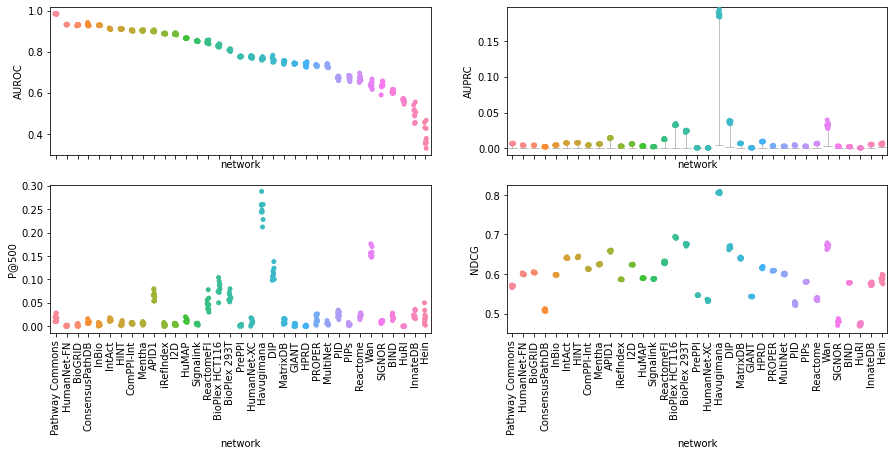

In [70]:
plot_all_metrics(corum_df, net_order="AUROC")

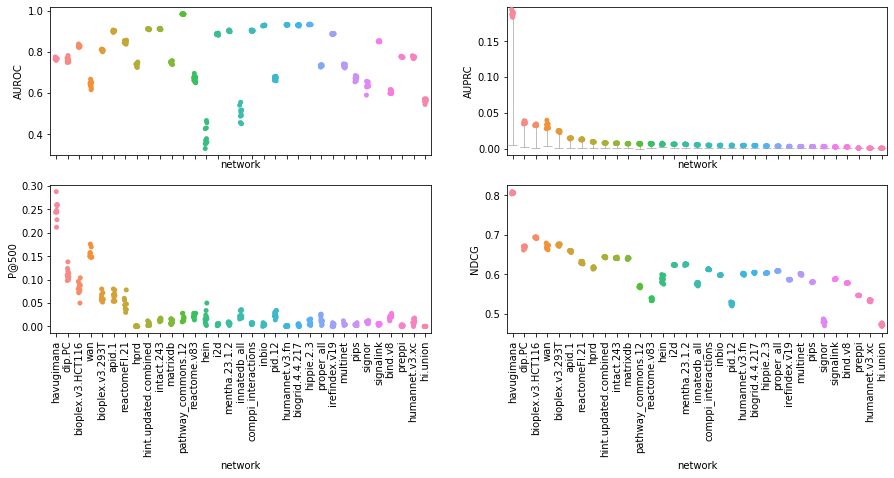

In [16]:
plot_all_metrics(corum_df, net_order="AUPRC")

## KEGG results

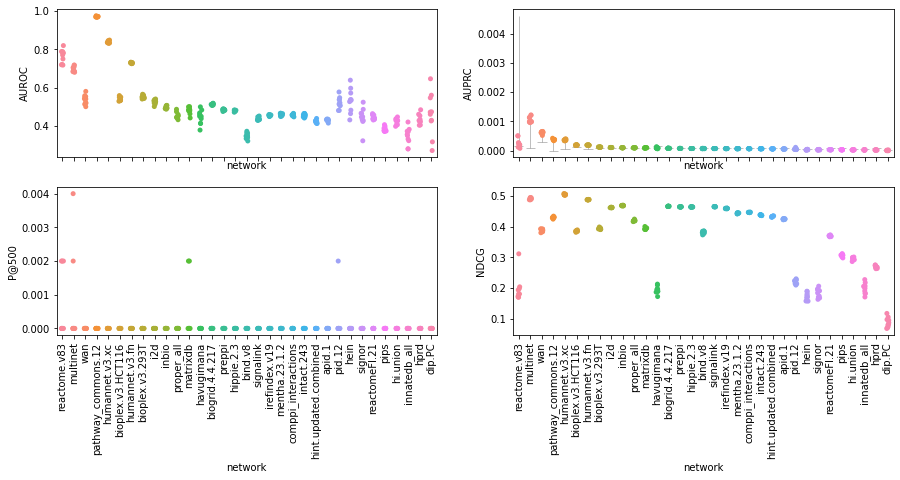

In [17]:
plot_all_metrics(kegg_df, net_order="AUPRC")

## PANTHER results

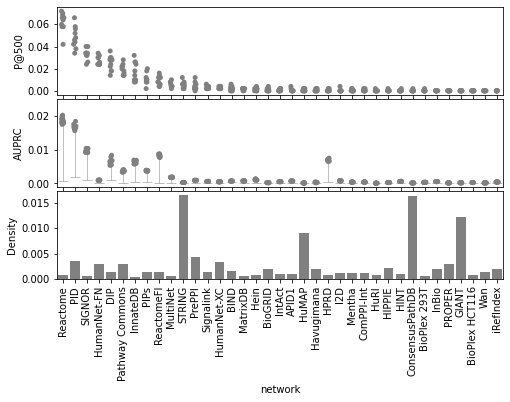

In [89]:
_, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace':0.05})
plot_metric(panther_df, net_order="P@500", metric="P@500", figsize=(8, 2), ax=axs[0], color='grey')
axs[0].set_xlabel('')

plot_metric(panther_df, net_order="P@500", metric="AUPRC", figsize=(8, 2), ax=axs[1], color='grey')
axs[1].set_xlabel('')
axs[1].set_ylim((-0.001, 0.025))
plot_metric(sizes_df, kind='bar',net_order=panther_df.groupby('network')['P@500'].mean().sort_values(ascending=False).index, metric='Density', figsize=(8,2), ax=axs[2], color='grey')
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/edge_predictions_panther_precision.svg', bbox_inches='tight', transparent=True, dpi=500)

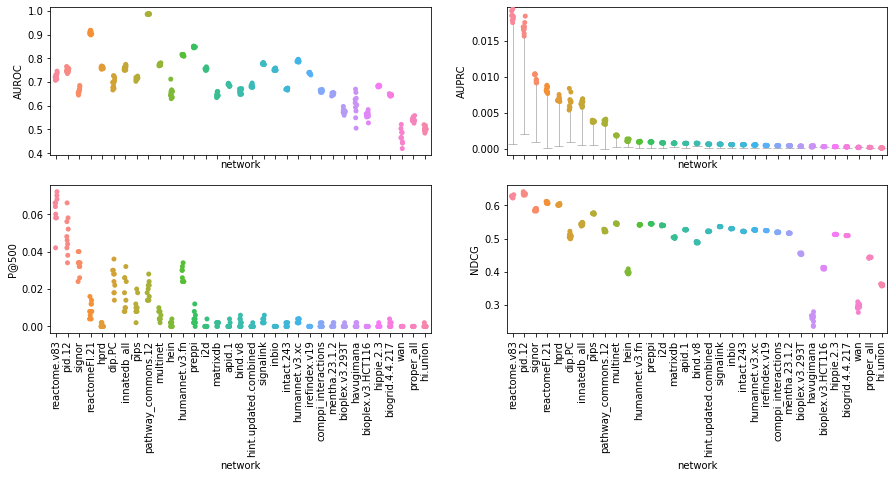

In [18]:
plot_all_metrics(panther_df, net_order="AUPRC")

## Viz development

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_heatmap(df, cluster_on=None, figsize=(8,10)):
    cmap_list = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'RdPu', 'Greys']
    if 'network' in df.columns:
        df = df.set_index('network', drop=True)
    fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=figsize, sharey=True, gridspec_kw={'wspace':0.1})
    
    nets = df.index
    if cluster_on is None:
        network_order = [nets[i] for i in leaves_list(linkage(df, method='ward'))]
    else:
        if type(cluster_on) == str:
            network_order = df.sort_values(cluster_on, ascending=False).index
        else:
            network_order = [nets[i] for i in leaves_list(linkage(df.loc[:, cluster_on], method='ward'))]
            

    # iterate over each metric
    for idx, metric in enumerate([col for col in df if col != 'network']):
        ax = axes[idx]
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes('right', size='5%', pad=0.05)


        # normalize data for better color spread
        heatmap_data = pd.pivot_table(df, values=metric, index='network')
        heatmap_data = heatmap_data.loc[network_order]
        if heatmap_data.max().max() < 0.01:
            fmt = ".0e"
        elif heatmap_data.min().min() > 100:
            fmt = ".0e"
        else:
            fmt = ".2f"

        sns.heatmap(heatmap_data, annot=True, fmt=fmt, linewidths=.5, ax=ax,
                    cmap=plt.get_cmap(cmap_list[idx]), cbar=False)

        ax.set_title(metric)
        ax.set_xlabel('')
        ax.set_xticks([])
        if idx > 0:
            ax.set_ylabel('')
            ax.tick_params(axis='y', which='both', length=0)
    
    plt.yticks(rotation=0)
    plt.show()


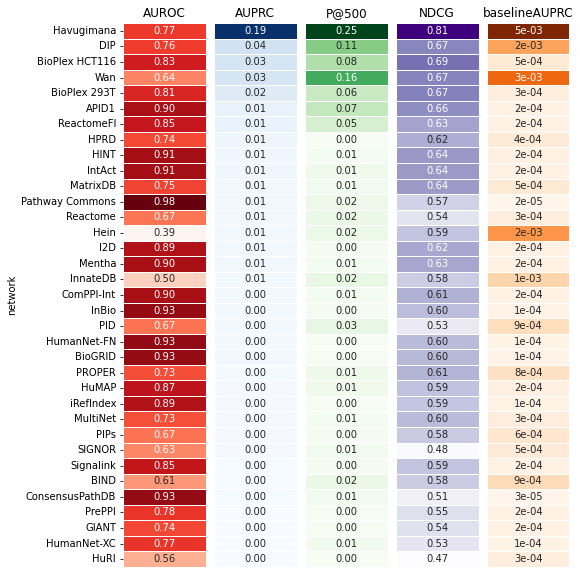

In [24]:
plot_heatmap(corum_df.drop(columns=['fold']).groupby('network').mean(), cluster_on='AUPRC')

## Add network stats

In [53]:
plot_df = corum_df.drop(columns=['fold']).groupby('network').mean().join(sizes_df, how='left')

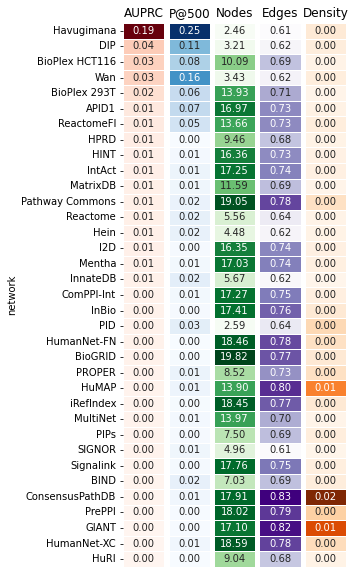

In [50]:
plot_heatmap(plot_df.drop(columns=['baselineAUPRC', 'NDCG', 'AUROC', 'Density']), cluster_on='AUPRC', figsize=(4, 10))

In [60]:
corum_order = plot_df.sort_values(by="AUPRC", ascending=False).index

In [65]:
corum_df

,fold,AUROC,AUPRC,P@500,NDCG,baselineAUPRC,network
0,0,0.610878,0.002274,0.024,0.577399,0.000944,BIND
1,1,0.598994,0.002214,0.012,0.578473,0.000946,BIND
2,2,0.602671,0.002248,0.018,0.578109,0.000943,BIND
3,3,0.616439,0.002296,0.024,0.577543,0.000927,BIND
4,4,0.598243,0.002248,0.020,0.578745,0.000942,BIND
...,...,...,...,...,...,...,...
5,5,0.685234,0.002968,0.002,0.581824,0.000628,PIPs
6,6,0.675001,0.002823,0.004,0.580098,0.000619,PIPs
7,7,0.658491,0.002740,0.004,0.580159,0.000621,PIPs
8,8,0.666619,0.002795,0.008,0.579849,0.000619,PIPs


In [38]:
plot_df = panther_df.drop(columns=['fold']).groupby('network').mean().join(sizes_df, how='left')

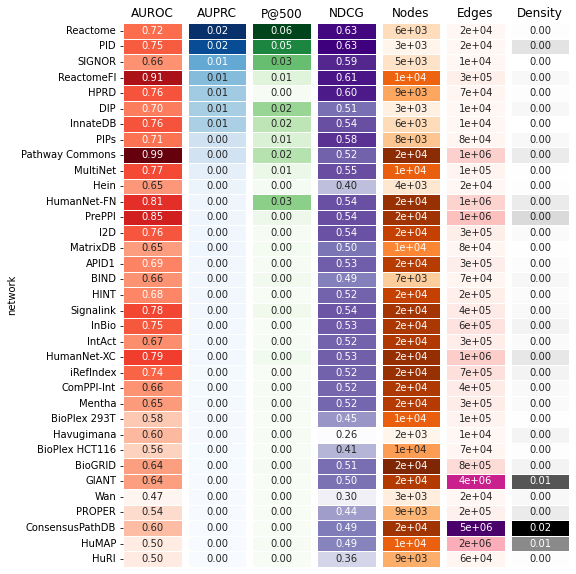

In [39]:
plot_heatmap(plot_df.drop(columns=['baselineAUPRC']), cluster_on="AUPRC")

<AxesSubplot:xlabel='Edges', ylabel='P@500'>

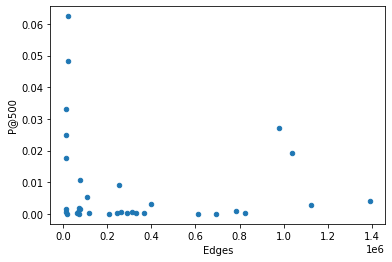

In [35]:
plot_df.plot(kind='scatter', x='Edges', y="P@500")